# Processing VIIRS

This short notebook will show you how to access VIIRS data from the cloud and visualize it.

## Using `satpy`

This section uses the Satpy library to process VIIRS data. [Satpy](https://satpy.readthedocs.io/en/stable/) is a powerful Python library used to access, remap, process, and visualize all sorts of satellite data. Let's install it.

In [46]:
!pip -q install satpy
!pip -q install s3fs
!pip -q install cartopy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 79.1 MB/s eta 0:00:00


In [23]:
%matplotlib inline
import matplotlib.pyplot as plt
import datetime
import s3fs
import os
import satpy
import numpy as np
import pyresample

### Finding data

We will access data through the NOAA Open Data Dissemination Program ([NODD](https://www.noaa.gov/information-technology/open-data-dissemination)). Here is the entrypoint for JPSS data on AWS: [https://registry.opendata.aws/noaa-jpss/](https://registry.opendata.aws/noaa-jpss/).

We will be using the Suomi-NPP satellite; the first with VIIRS. We will be looking at the I5 Band (`VIIRS-I5-SDR`), which is 375-m resolution 11.45-µm imagery.

The granule below covers part of Mexico.

Note well that we need to download the geolocation data separately! See the list [here](https://satellite-resources.readthedocs.io/en/latest/Low-Earth-orbit.html#geolocation-files) for geolocation file specifications corresponding to different VIIRS products.


In [17]:
fs = s3fs.S3FileSystem(anon=True)

dt = datetime.datetime(2024,8,9,19,50)

# Band I5
file_location = fs.glob(dt.strftime('s3://noaa-nesdis-snpp-pds/VIIRS-I5-SDR/%Y/%m/%d/SVI05_npp_d%Y%m%d_t%H%M*.h5'))
_ = fs.download(file_location[0], os.path.basename(file_location[0]))

# Geolocation data
# "TC" means terrain-corrected
file_location = fs.glob(dt.strftime('s3://noaa-nesdis-snpp-pds/VIIRS-IMG-GEO-TC/%Y/%m/%d/GITCO_npp_d%Y%m%d_t%H%M*.h5'))
_ = fs.download(file_location[0], os.path.basename(file_location[0]))


In [65]:
!ls -lh *h5 # See the files

-rw-r--r-- 1 root root 99M Aug 19 15:24 GITCO_npp_d20240809_t1950466_e1952108_b66248_c20240809201954830000_oebc_ops.h5
-rw-r--r-- 1 root root 24M Aug 19 15:24 SVI05_npp_d20240809_t1950466_e1952108_b66248_c20240809202158412000_oebc_ops.h5


### Reading data

Now we can read the downloaded HDF5 files with `satpy`.

['I05', 'i_latitude', 'i_longitude', 'satellite_azimuth_angle', 'satellite_zenith_angle', 'solar_azimuth_angle', 'solar_zenith_angle']


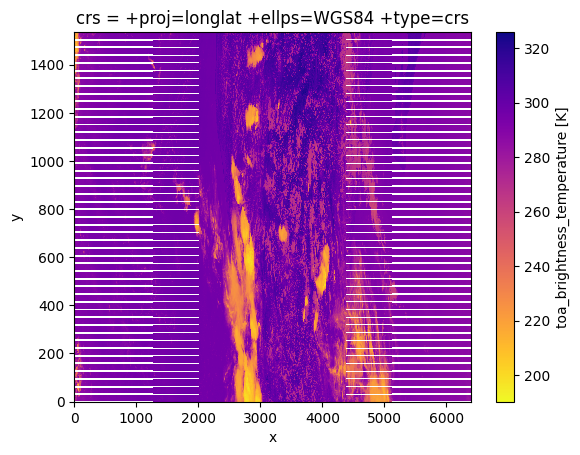

In [66]:
import glob

filenames = glob.glob("*.h5")

# note the reader, 'viirs_sdr'
scene = satpy.Scene(reader='viirs_sdr', filenames=filenames)

# See the available datasets. A Scene can contain multiple bands
print(scene.available_dataset_names())

# "Load" the data
scene.load(['I05'])

# Make an image.
plt.figure()
scene['I05'].plot.imshow(cmap='plasma_r')
plt.show()

The edges of this plot look a bit strange. This effect is caused by the scanning pattern of the VIIRS instrument, and is known as the "bow-tie effect" where pixels from consecutive scans overlap on the edges of the swath. In this case, the duplicate pixels from the overlap are actually removed from the data.

### Remapping data

A simple way to get rid of the bow-tie-deleted pixels is to remap the data. Let's make a `GridDefinition` and perform the remapping. I happen to know that this granule is over part of Mexico.

In [67]:
lats = np.arange(33.5, 15, -0.05)
lons = np.arange(-118, -83, 0.05)

lons, lats = np.meshgrid(lons, lats)

my_grid = pyresample.geometry.GridDefinition(lats=lats, lons=lons)

new_scn = scene.resample(my_grid)


### Visualizing data

Now let's make an image with a map.

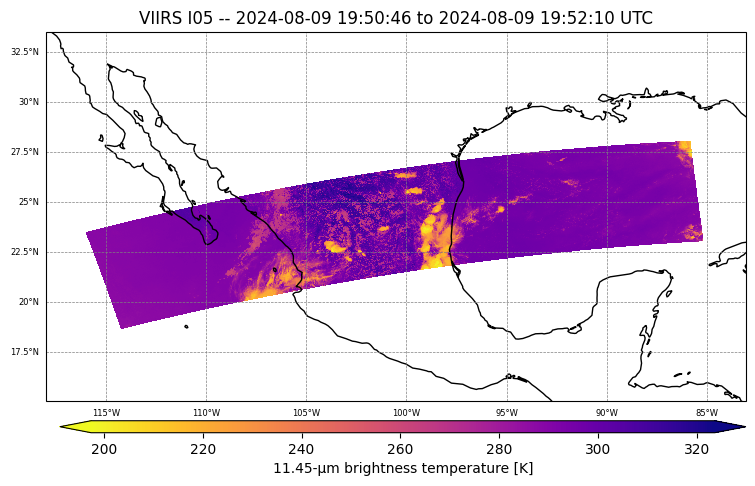

In [70]:
import cartopy.crs as ccrs

# Set up the figure
fig = plt.figure(figsize=(7, 4))
ax = fig.add_axes([0, 0, 1, 1], projection=ccrs.PlateCarree())
ax.coastlines()

# Get the data and use imshow to visualize
ir_data = new_scn["I05"].compute().data

img = ax.imshow(
    ir_data,
    transform=ccrs.PlateCarree(),
    extent=[lons.min(), lons.max(), lats.min(), lats.max()],
    cmap=plt.get_cmap("plasma_r"),
)

# Plotting extras
st = new_scn["I05"].attrs["start_time"]
et = new_scn["I05"].attrs["end_time"]
plt.title(f'VIIRS I05 -- {st.strftime("%Y-%m-%d %H:%M:%S")} to {et.strftime("%Y-%m-%d %H:%M:%S UTC")}')

cbar_axes = [0.02, -0.04, 0.98, 0.03] # left bottom width height

cbaxes2 = fig.add_axes(cbar_axes)
cbar2 = plt.colorbar(
   img,
    orientation="horizontal",
    extend="both",
    ax=ax,
    cax=cbaxes2,
)
cbar2.set_label('11.45-µm brightness temperature [K]', fontsize=10)

gl = ax.gridlines(
  crs=ccrs.PlateCarree(),
  draw_labels=True,
  linewidth=0.5,
  color="gray",
  linestyle="--",
)
# Customize the gridline labels
gl.top_labels = None
gl.right_labels = None
gl.xlabel_style = {"size": 6}
gl.ylabel_style = {"size": 6}

This granule is comprised of only about 90 seconds worth of data. The two limbs of the swath span from the east Pacific Ocean to the Gulf of Mexico.

The granule is on an "ascending node." That is, the satellite is "ascending" from the south pole towards the north pole. You can tell this because the swath is oriented southeast-to-northwest (for JPSS satellites). You can also tell by looking at the [orbit tracks from the University of Wisconsin](https://www.ssec.wisc.edu/datacenter/polar_orbit_tracks). The "descending node" is when the satellite moves from the north pole to the south pole.

<img src="https://www.ssec.wisc.edu/datacenter/polar_orbit_tracks/data/NPP/2024/2024_08_09_222/GLOBAL.gif">